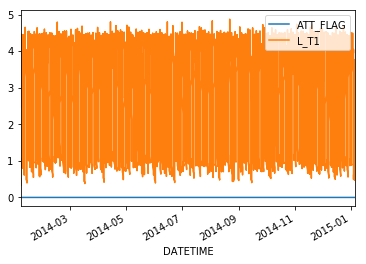

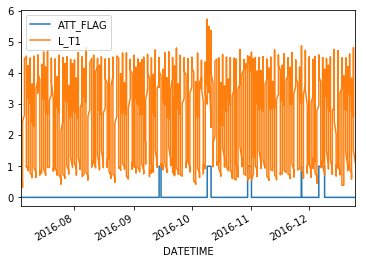

In [438]:
from pandas import read_csv
from pandas import datetime
import pandas
from nltk import ngrams
import math
from matplotlib import pyplot
from sklearn.preprocessing import scale
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import robust_scale
import time
from sklearn.decomposition import PCA
import scipy.stats
import matplotlib.pyplot as plt
from  sklearn.metrics import confusion_matrix
from numpy import linalg as LA
import numpy as np
def parse_date(x):    
    date = str(x).split(' ')[0]
    time_stamp = datetime.strptime(date,'%d/%m/%y')
    return time_stamp
df_1 = read_csv('BATADAL_dataset_training_1.csv',parse_dates=[0],date_parser=parse_date, skipinitialspace=True)
df_2 = read_csv('BATADAL_dataset_training_2.csv',parse_dates=[0],date_parser=parse_date, skipinitialspace=True)
df_1['ATT_FLAG'] = -df_1['ATT_FLAG']/1000 + 1/1000
df_2['ATT_FLAG'] = 1-(-df_2['ATT_FLAG']/1000 + 1/1000)
cols = ['ATT_FLAG', 'L_T1']
df_1.plot(x='DATETIME', y= cols)
df_2.plot(x='DATETIME', y= cols)
pyplot.show()

In [393]:
def convert_df(df, norm=True) :
    labels = df['ATT_FLAG'].values
    x_df = df.drop('ATT_FLAG',1).drop('DATETIME', 1)
    x = x_df.values
    (n,m) = x.shape
    if norm:
        x = robust_scale(x)
    return (x, labels, n,m)


(x_1, y_1, n_1, m_1) = convert_df(df_1)
(x_2, y_2, n_2, m_2) = convert_df(df_2)

PCA Task:

In [360]:
#Splits principal axes in normal and anomalous sets
#Outputs index of column which first exceeds the threshold

def seperate_anomalous(x_norm,t,m):
    i = 0
    for i in range(0, m):
        u = x_norm[:,i]
        mu = np.mean(u)
        std = math.sqrt(np.std(u))
        t_min = mu-(std*t)
        t_max = mu+(std*t)
        breach= np.any(u<t_min) or np.any(u>t_max)
        if breach:
            break
    return i

#Calculates the Squared Prediction Error for all residual data
def calc_SPE(x_a,n):
    spes = np.empty([n])
    for i in range(0,n):
        y = x_a[:,i] 
        spes[i] = np.dot(y, y.T)
    return spes

#Calculates the Q-statistic on the residual data
def calc_q_stat(alpha, x, comps,r,m):
    phi_1 = calc_phi(1,m,r,x,comps)
    phi_2 = calc_phi(2,m,r,x,comps)
    phi_3 = calc_phi(3,m,r,x,comps)
    h_0 = 1 - ((2*phi_1*phi_3)/(3*phi_2**2))
    c_a = scipy.stats.norm.ppf(1-alpha)
    
    left_part = c_a * math.sqrt(2*phi_2* h_0**2)/phi_1
    right_part = phi_2* h_0*(h_0-1) /phi_1**2 
    
    center_part = left_part+1+right_part

    d2_a = phi_1 * center_part**(1/h_0)
    return d2_a

#Helper function for calculating the Q-statistic 
def calc_phi(i,m,r,x,comps):  
    res = 0
    for j in range(r+1,m):
        v_j = comps[:,j]
        xv = np.dot(x,v_j)
        l_j = LA.norm(xv)
        res = res + l_j**i
    return res

#Initiates the PCA-based anomality detection on the given dataset 
#Outputs a list of all datapoints deemed as abnomal
def init_pca(n,m,x,y,alpha,t):
    pca = PCA(n_components=m)
    pca.fit(x)
    proj_x = pca.transform(x)
    norm_x = normalize(proj_x, norm='l1', axis=0)
    idx =  seperate_anomalous(norm_x, t,m)  
    r= idx-1
    prin_comps = pca.components_
    P = prin_comps[:,0:r]
    C = np.dot(P, P.T)
    I = np.identity(m)

    x_n = np.dot(C, x.T)
    x_a = np.dot(I-C, x.T)
    spes = calc_SPE(x_a,n)
    q_stat = calc_q_stat(alpha, x_2, prin_comps,r,m)
    abnomal = spes > q_stat
    return abnomal

#Tunes threshold and alpha values on given dataset   
def tune_params(cand_alpha,cand_t,n,m,x,y):
    best_t = 0
    best_a = 0
    fp_v = n*m

    for alpha in cand_alpha:
        for t in cand_t:
            pred_y = init_pca(n, m, x, y, alpha,t)
            #print("Alpha: " +str(alpha))
            #print("threshold: "+ str(t))
            #print(confusion_matrix(y, pred_y))
            tn, fp, fn, tp = confusion_matrix(y, pred_y).ravel()
            if fp < fp_v:
                best_t = t
                best_a = alpha
                fp_v = fp 
    return (best_t, best_a)

C:\Users\vasco\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\vasco\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in greater
C:\Users\vasco\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\vasco\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in greater
C:\Users\vasco\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\vasco\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in greater
C:\Users\vasco\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\vasco\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in grea

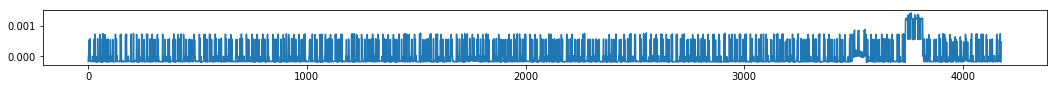

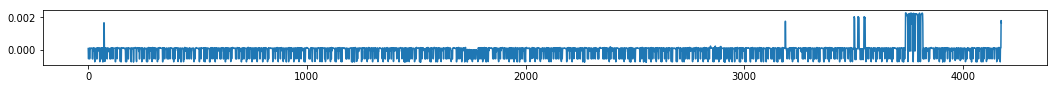

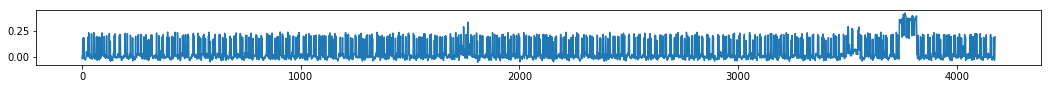

In [361]:
#Test dataset2 and tune the parameters
cand_alpha = [0.5, 0.75, 0.9, 0.99,0.999]
cand_t = [0.5, 1, 2,3,5,10,25, 50]
x =x_2
y = y_2
m = m_2
n = n_2

pca = PCA(n_components=m)
pca.fit(x)
proj_x = pca.transform(x)
norm_x = normalize(proj_x, norm='l1', axis=0)

#Plot the first two principal axes for reference
plt.figure(figsize=(18,1))
plt.plot(norm_x[:,0])
plt.figure(figsize=(18,1))
plt.plot(norm_x[:,1])

(t,a) = tune_params(cand_alpha, cand_t, n, m, x, y)
idx =  seperate_anomalous(norm_x, t,m) 
r= idx-1
prin_comps = pca.components_
P = prin_comps[:,0:r]
C = np.dot(P, P.T)
I = np.identity(m)

x_n = np.dot(C, x.T)
x_a = np.dot(I-C, x.T)
#Plot the redidual part
plt.figure(figsize=(18,1))
plt.plot(x_a[0,:])




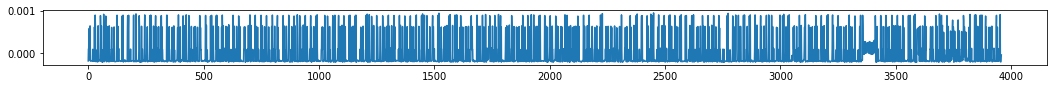

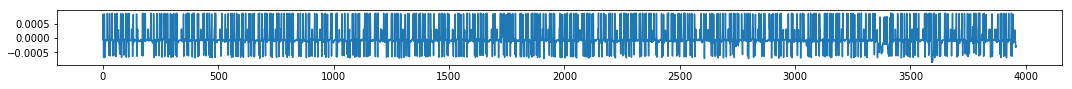

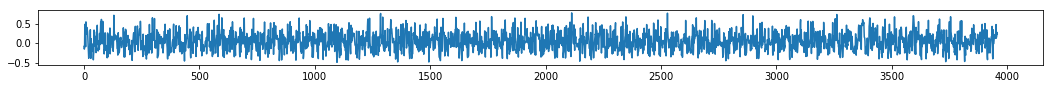

In [355]:
#Test dataset2 with removed abnomalities
clean_x = x_2[y_2==0 ,:]
clean_y = y_2[y_2==0]
x = clean_x
y = clean_y
(n,m) = clean_x.shape

pca = PCA(n_components=m)
pca.fit(x)
proj_x = pca.transform(x)
norm_x = normalize(proj_x, norm='l1', axis=0)

#Plot the first two principal axes for reference
plt.figure(figsize=(18,1))
plt.plot(norm_x[:,0])
plt.figure(figsize=(18,1))
plt.plot(norm_x[:,1])

idx =  seperate_anomalous(norm_x, t,m) 
r= idx-1
prin_comps = pca.components_
P = prin_comps[:,0:r]
C = np.dot(P, P.T)
I = np.identity(m)

x_n = np.dot(C, x.T)
x_a = np.dot(I-C, x.T)
#Plot the redidual part
plt.figure(figsize=(18,1))
plt.plot(x_a[0,:])



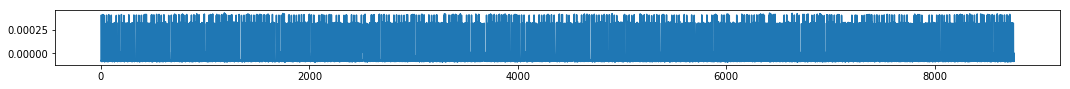

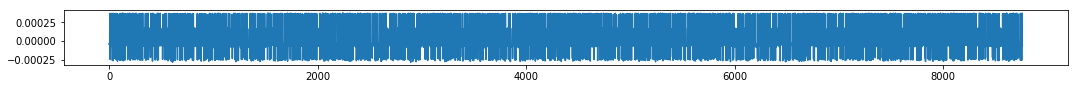

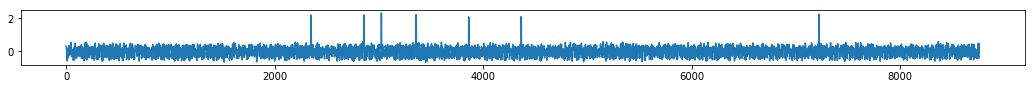

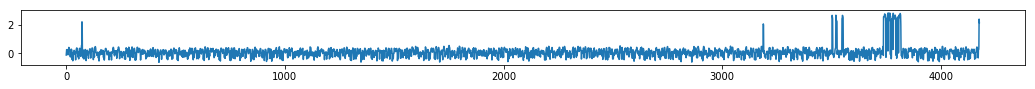

In [362]:
#Test dataset 1
x = x_1
y = y_1
(n,m) = x.shape

pca = PCA(n_components=m)
pca.fit(x)
proj_x = pca.transform(x)
norm_x = normalize(proj_x, norm='l1', axis=0)

plt.figure(figsize=(18,1))
plt.plot(norm_x[:,0])
plt.figure(figsize=(18,1))
plt.plot(norm_x[:,1])

idx =  seperate_anomalous(norm_x, t,m) 
r= idx-1
prin_comps = pca.components_
P = prin_comps[:,0:r]
C = np.dot(P, P.T)
I = np.identity(m)

x_n = np.dot(C, x.T)
x_a = np.dot(I-C, x.T)

plt.figure(figsize=(18,1))
plt.plot(x_a[0,:])

x_2_a = np.dot(I-C, x_2.T)
plt.figure(figsize=(18,1))
plt.plot(x_2_a[0,:])


Discrete models task

TypeError: 'generator' object is not callable

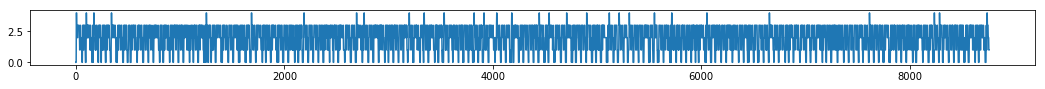

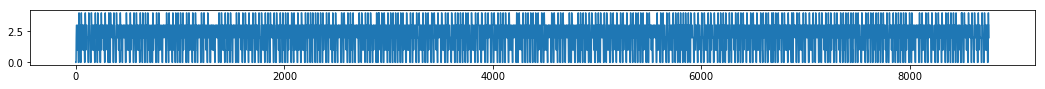

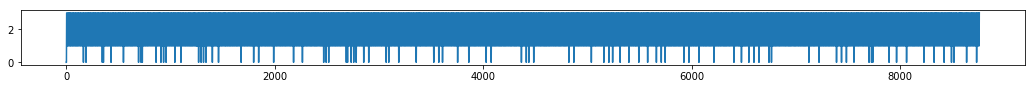

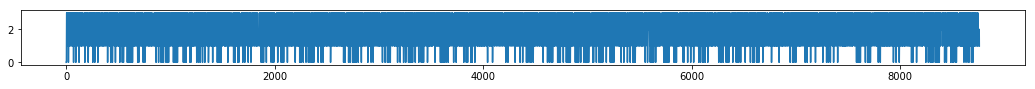

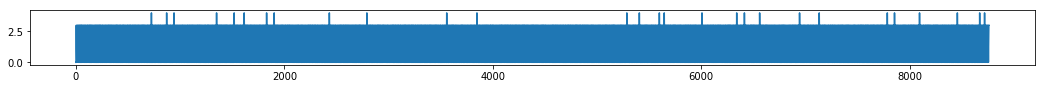

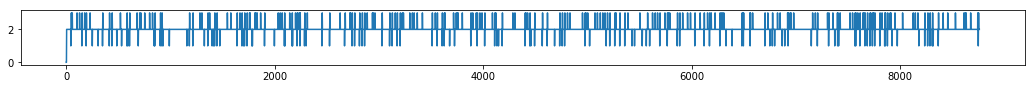

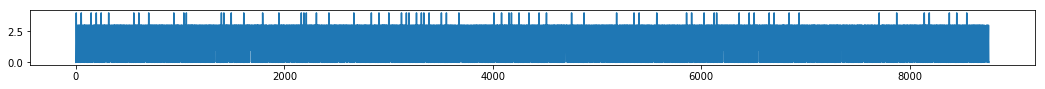

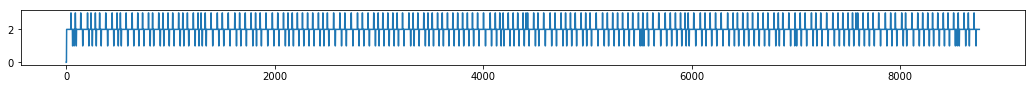

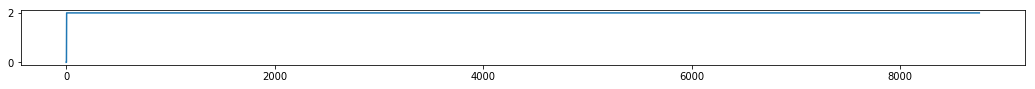

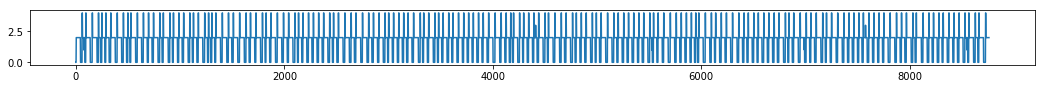

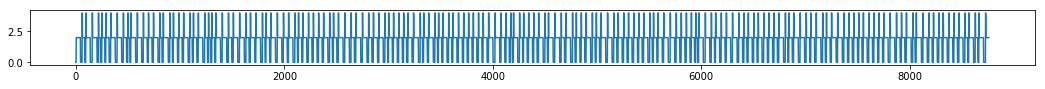

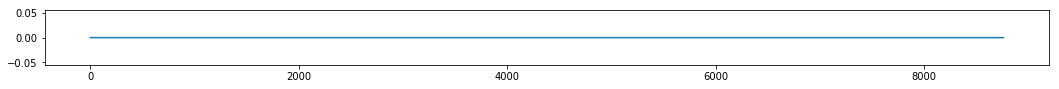

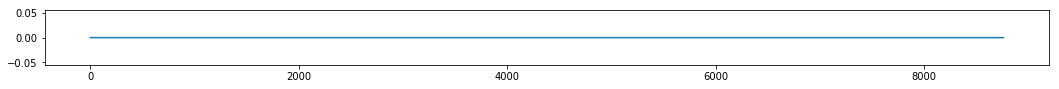

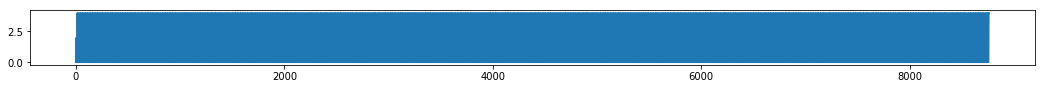

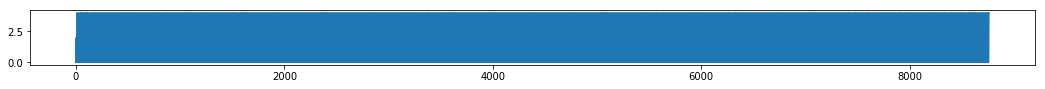

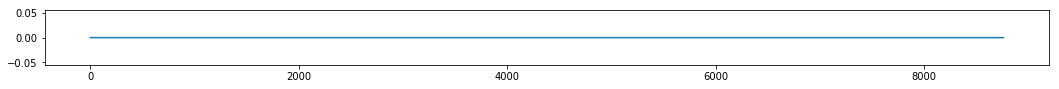

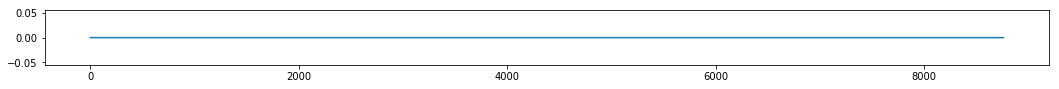

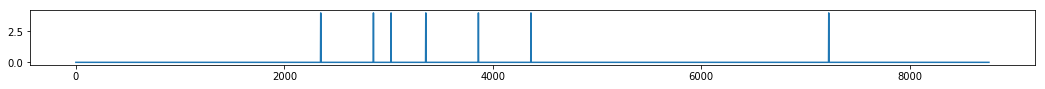

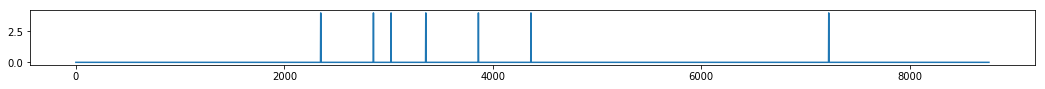

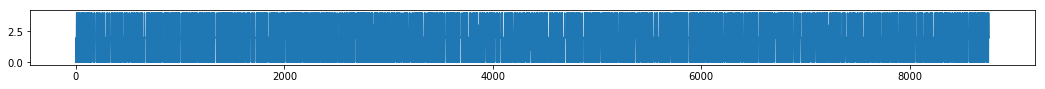

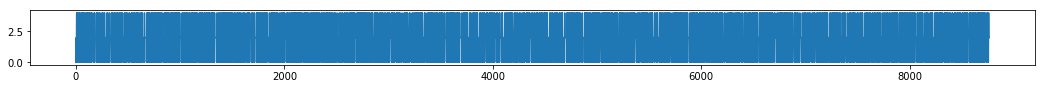

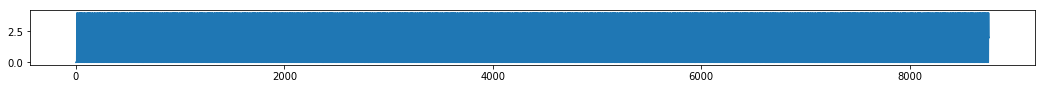

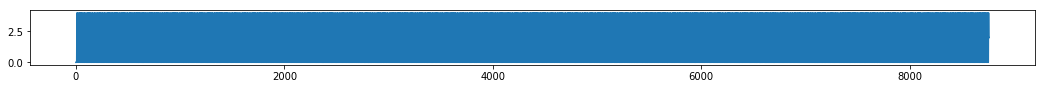

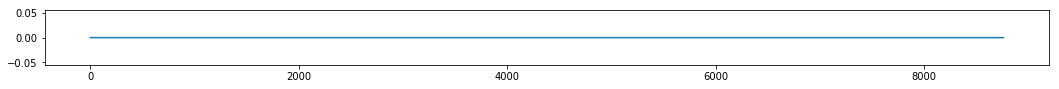

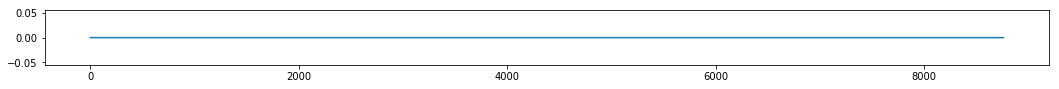

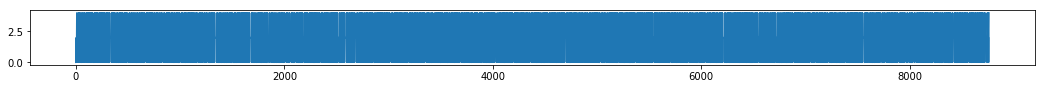

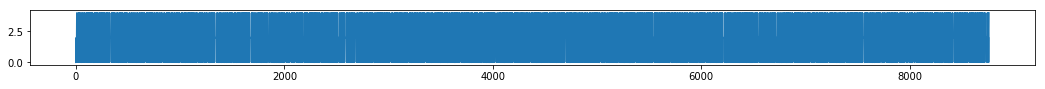

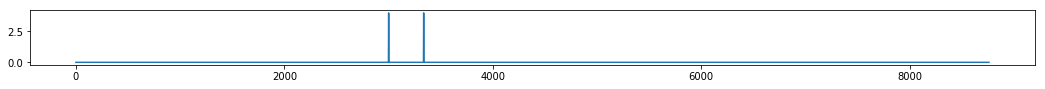

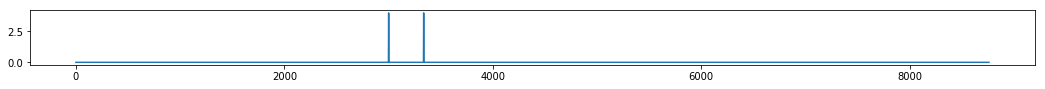

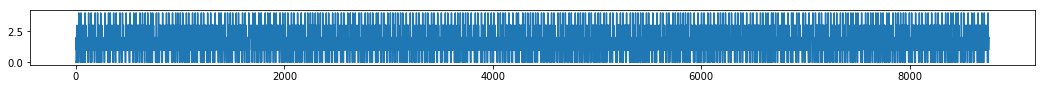

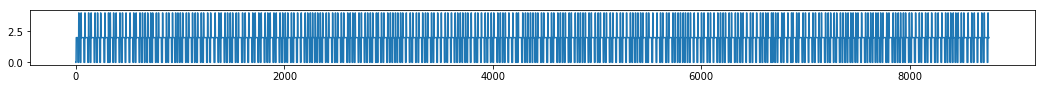

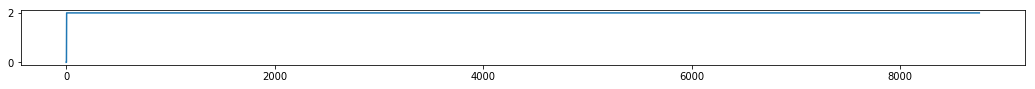

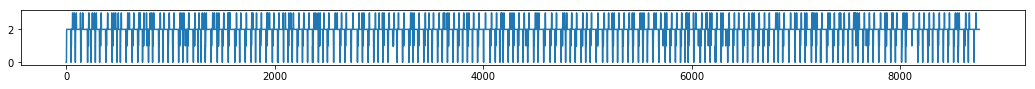

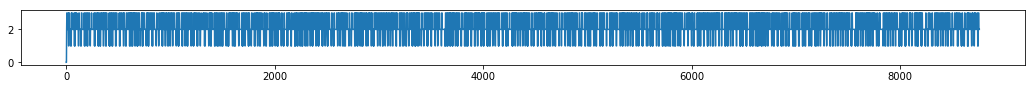

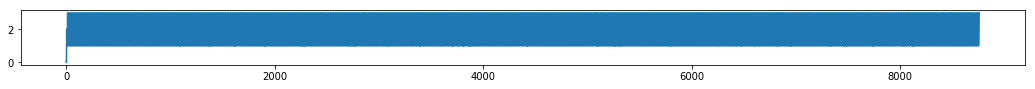

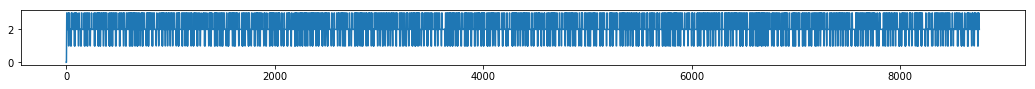

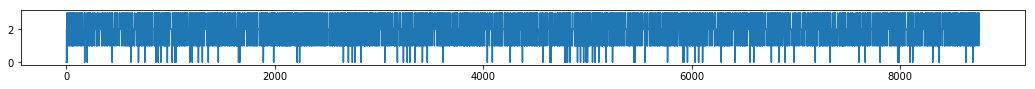

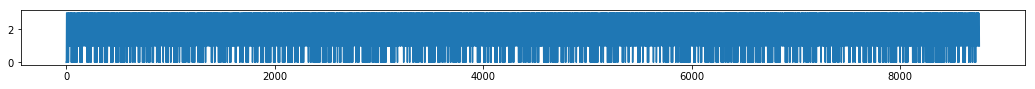

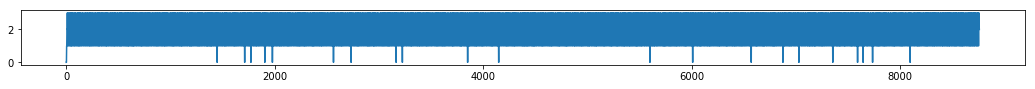

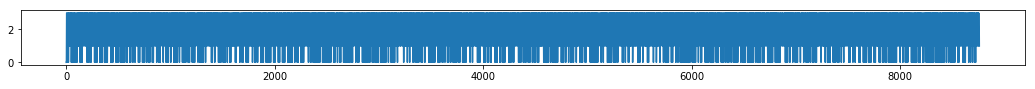

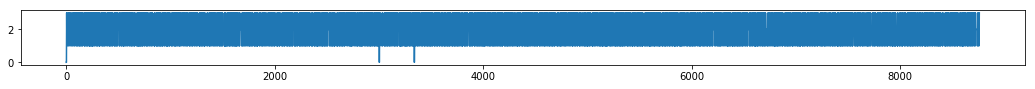

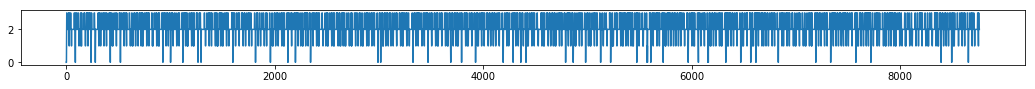

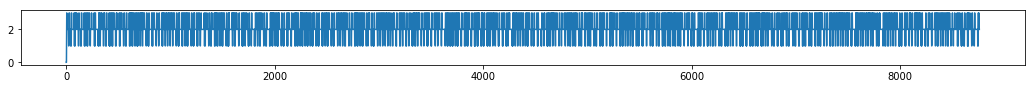

In [427]:
(x, y, n, m) = convert_df(df_1, norm=False)
p=3
t = 0.5


#Use change point detection to discretize
#Based on percent change over given number of periods
disc_sensors = []
for j in range(0,m):
    sensor_data = x[:,j]
    s = pandas.Series(sensor_data)
    changes = s.pct_change(periods=p)
    pos_t = t*max_v
    neg_t = t*min_v
    disc = (changes > pos_t).astype(int) + (changes > 0.1).astype(int) + (changes > -0.1).astype(int) +(changes > neg_t).astype(int) 
    plt.figure(figsize=(18,1))
    plt.plot(disc)
    disc_sensors.append(disc)
#Use ngrams

#Size of sliding window
sw_size =3 
states = ["QD", "SD", "C", "SU", "QU"]


In [551]:
#Markov Chain
sw_size =10 
states = ["QD", "SD", "C", "SU", "QU"]
#disc_states = states[disc.values]
disc_states = []
for state in disc:
    disc_states.append(states[state])
bi_grams = ngrams(disc_states, 2)

p_dict = {}
p_dict_start = {}


#Smoothe and initialize the transition matrix and init matrix
for state in states:
    p_dict[state] = {}
    p_dict_start[state] = 1
    for to_state in states:
        p_dict[state][to_state] = 1

#Add all starting states to init matrix        
for state in disc_states:
    p_dict_start[state] = p_dict_start[state]+1    
#Add all the bigrams  to the transition matrix       
for pair in bi_grams:
    (src, dest)= pair
    p_dict[src][dest] = p_dict[src][dest] +1
    
#Normalize
total_init = len(states) + len(disc_states)
for src in states:
    p_dict_start[src] = p_dict_start[src]/total_init
    total_trans = 0
    for dest in states:
        total_trans = total_trans + p_dict[src][dest]
    for dest in states:
        p_dict[src][dest] = p_dict[src][dest]/total_trans

threshold = 0.0001
for i in range(0,n-sw_size):
    slc = disc_states[i:i+sw_size]
    p = p_dict_start[slc[0]]
    trans = ngrams(slc, 2)
    for transition in trans:
        (src, dst) = transition
        p = p * p_dict[src][dest] 
    print(p)


7.208899337143614e-29
9.423397826331522e-32
1.231816709324382e-34
2.462425755208249e-34
2.462425755208249e-34
5.780682335260825e-35
5.793942953431175e-35
5.793942953431175e-35
5.793942953431175e-35
5.793942953431175e-35
5.793942953431175e-35
5.793942953431175e-35
5.793942953431175e-35
5.793942953431175e-35
2.925654362623663e-34
1.4773106187505628e-33
7.459687282799871e-33
3.766772786364291e-32
3.7667727863642914e-32
1.600878434204824e-31
6.803733345370503e-31
2.8915866717824637e-30
2.426909591782111e-30
4.806232720980258e-31
9.518225584686395e-32
1.884981929516325e-32
1.8902965211465838e-32
4.437576923927569e-33
1.0441357468064868e-33
2.456789992485851e-34
5.780682335260825e-35
5.793942953431175e-35
5.793942953431175e-35
5.793942953431175e-35
5.793942953431175e-35
2.925654362623663e-34
2.9256543626236633e-34
2.9256543626236633e-34
1.4773106187505624e-33
7.45968728279987e-33
3.766772786364292e-32
1.600878434204824e-31
6.803733345370503e-31
5.710375510075554e-31
5.726475565686839e-31
5.7

5.793942953431175e-35
2.925654362623663e-34
1.4773106187505628e-33
1.4773106187505626e-33
7.45968728279987e-33
3.766772786364291e-32
1.9020337832136523e-31
8.083643578658023e-31
3.4355485209296605e-30
2.883456940731221e-30
5.710375510075554e-31
2.4337521154169074e-30
2.04264890641661e-30
4.045245873491717e-31
8.011173200444383e-32
1.8859701926692165e-32
4.437576923927569e-33
1.0441357468064868e-33
1.0465309459635062e-33
2.456789992485851e-34
5.780682335260825e-35
5.793942953431175e-35
5.793942953431175e-35
5.793942953431175e-35
5.793942953431175e-35
5.793942953431175e-35
5.793942953431175e-35
5.793942953431175e-35
5.793942953431175e-35
5.793942953431175e-35
5.793942953431175e-35
5.793942953431175e-35
5.793942953431175e-35
5.793942953431175e-35
5.793942953431175e-35
2.4624257552082496e-34
1.0465309459635062e-33
1.0465309459635062e-33
5.284463192488991e-33
2.6683923051182036e-32
2.6683923051182036e-32
1.3474060154557267e-31
6.803733345370504e-31
8.065142514394298e-31
1.8976805916221874e-

2.462425755208249e-34
2.462425755208249e-34
2.462425755208249e-34
2.462425755208249e-34
2.462425755208249e-34
5.780682335260825e-35
5.793942953431175e-35
5.793942953431175e-35
5.793942953431175e-35
5.793942953431175e-35
5.793942953431175e-35
2.925654362623663e-34
1.4773106187505628e-33
7.459687282799871e-33
3.766772786364291e-32
1.9020337832136523e-31
1.9020337832136523e-31
8.083643578658023e-31
3.4355485209296605e-30
2.883456940731221e-30
2.426909591782111e-30
2.0426489064166098e-30
4.045245873491718e-31
8.011173200444382e-32
8.033760214872981e-32
1.8859701926692174e-32
4.437576923927569e-33
1.0441357468064868e-33
2.456789992485851e-34
5.780682335260825e-35
5.793942953431175e-35
5.793942953431175e-35
5.793942953431175e-35
5.793942953431175e-35
2.925654362623663e-34
2.9256543626236633e-34
2.9256543626236633e-34
1.4773106187505624e-33
7.45968728279987e-33
3.766772786364292e-32
1.600878434204824e-31
6.803733345370503e-31
5.710375510075554e-31
2.433752115416907e-30
1.0343446490521858e-29


1.0441357468064868e-33
2.456789992485851e-34
2.462425755208249e-34
5.780682335260825e-35
2.4624257552082496e-34
1.0465309459635062e-33
1.0465309459635062e-33
1.046530945963506e-33
1.046530945963506e-33
1.046530945963506e-33
1.046530945963506e-33
1.0465309459635062e-33
2.456789992485851e-34
5.780682335260825e-35
5.793942953431175e-35
5.793942953431175e-35
5.793942953431175e-35
5.793942953431175e-35
5.793942953431175e-35
5.793942953431175e-35
5.793942953431175e-35
2.925654362623663e-34
1.4773106187505628e-33
7.459687282799871e-33
7.45968728279987e-33
7.459687282799871e-33
7.459687282799871e-33
3.1703670951899456e-32
1.3474060154557272e-31
1.1308782872894724e-31
2.239582490514446e-32
4.435251598861941e-33
4.447756520344901e-33
4.447756520344901e-33
4.447756520344901e-33
1.0441357468064868e-33
2.456789992485851e-34
5.780682335260825e-35
5.793942953431175e-35
5.793942953431175e-35
5.793942953431175e-35
5.793942953431175e-35
5.793942953431175e-35
5.793942953431175e-35
5.793942953431175e-35
5

7.459687282799871e-33
7.459687282799871e-33
3.1703670951899456e-32
1.3474060154557272e-31
2.660890087739935e-32
5.26960586003399e-33
1.0435886114969273e-33
1.046530945963506e-33
1.046530945963506e-33
1.0465309459635062e-33
2.456789992485851e-34
5.780682335260825e-35
5.793942953431175e-35
5.793942953431175e-35
5.793942953431175e-35
5.793942953431175e-35
5.793942953431175e-35
5.793942953431175e-35
5.793942953431175e-35
5.793942953431175e-35
2.925654362623663e-34
1.4773106187505628e-33
7.459687282799871e-33
7.45968728279987e-33
7.459687282799871e-33
7.459687282799871e-33
3.1703670951899456e-32
1.3474060154557272e-31
1.1308782872894724e-31
2.239582490514446e-32
4.435251598861941e-33
4.447756520344901e-33
4.447756520344901e-33
4.447756520344901e-33
1.0441357468064868e-33
2.456789992485851e-34
5.780682335260825e-35
5.793942953431175e-35
2.4624257552082496e-34
2.4624257552082496e-34
2.4624257552082496e-34
1.2434031041150567e-33
6.27857012968989e-33
6.27857012968989e-33
3.170367095189945e-32
3

1.0465309459635062e-33
5.284463192488991e-33
2.6683923051182036e-32
1.3474060154557267e-31
6.803733345370502e-31
3.4355485209296605e-30
4.07249770528821e-30
9.582347541854611e-31
4.0818398268471215e-30
3.425889434532143e-30
2.883456940731221e-30
2.426909591782111e-30
4.806232720980258e-31
9.518225584686395e-32
1.884981929516325e-32
1.8902965211465838e-32
4.437576923927569e-33
1.0441357468064868e-33
2.456789992485851e-34
5.780682335260825e-35
5.793942953431175e-35
2.4624257552082496e-34
1.0465309459635062e-33
1.0465309459635062e-33
1.046530945963506e-33
1.046530945963506e-33
1.046530945963506e-33
1.046530945963506e-33
5.2844631924889925e-33
6.264200343550338e-33
7.442614269564758e-33
7.45968728279987e-33
7.459687282799871e-33
7.459687282799871e-33
3.1703670951899456e-32
1.3474060154557272e-31
1.1308782872894724e-31
2.239582490514446e-32
4.435251598861941e-33
4.447756520344901e-33
4.447756520344901e-33
4.447756520344901e-33
1.0441357468064868e-33
2.456789992485851e-34
2.456789992485851e-

4.435251598861941e-33
4.447756520344901e-33
4.447756520344901e-33
1.0441357468064868e-33
2.456789992485851e-34
5.780682335260825e-35
2.4624257552082496e-34
1.0465309459635062e-33
1.0465309459635062e-33
1.046530945963506e-33
1.046530945963506e-33
1.046530945963506e-33
5.284463192488991e-33
2.668392305118204e-32
3.163111064565022e-32
3.7581517598792343e-32
3.7667727863642914e-32
3.7667727863642914e-32
1.600878434204824e-31
6.803733345370503e-31
5.710375510075554e-31
1.1308782872894724e-31
2.239582490514446e-32
4.435251598861941e-33
4.447756520344901e-33
4.447756520344901e-33
1.0441357468064868e-33
2.456789992485851e-34
5.780682335260825e-35
2.4624257552082496e-34
1.0465309459635062e-33
1.0465309459635062e-33
1.046530945963506e-33
1.046530945963506e-33
1.046530945963506e-33
1.046530945963506e-33
1.0465309459635062e-33
2.456789992485851e-34
5.780682335260825e-35
5.793942953431175e-35
5.793942953431175e-35
5.793942953431175e-35
5.793942953431175e-35
5.793942953431175e-35
2.4624257552082496e

1.9020337832136523e-31
1.9020337832136523e-31
8.083643578658023e-31
3.4355485209296605e-30
2.883456940731221e-30
5.710375510075554e-31
1.1308782872894722e-31
2.2395824905144453e-32
4.4352515988619404e-33
4.447756520344901e-33
1.0441357468064868e-33
2.456789992485851e-34
5.780682335260825e-35
2.4624257552082496e-34
1.0465309459635062e-33
1.0465309459635062e-33
1.046530945963506e-33
1.046530945963506e-33
1.046530945963506e-33
5.284463192488991e-33
2.668392305118204e-32
3.163111064565022e-32
3.7581517598792343e-32
1.9020337832136523e-31
1.9020337832136523e-31
8.083643578658023e-31
3.4355485209296605e-30
2.883456940731221e-30
5.710375510075554e-31
1.1308782872894722e-31
2.2395824905144453e-32
4.4352515988619404e-33
4.447756520344901e-33
1.0441357468064868e-33
2.456789992485851e-34
5.780682335260825e-35
5.793942953431175e-35
2.4624257552082496e-34
2.4624257552082496e-34
2.4624257552082496e-34
2.462425755208249e-34
1.046530945963506e-33
1.046530945963506e-33
1.046530945963506e-33
1.046530945

1.0465309459635062e-33
1.0465309459635062e-33
1.046530945963506e-33
1.046530945963506e-33
1.046530945963506e-33
1.046530945963506e-33
5.2844631924889925e-33
6.264200343550338e-33
7.442614269564758e-33
3.766772786364291e-32
3.7667727863642914e-32
1.600878434204824e-31
6.803733345370503e-31
2.8915866717824637e-30
5.710375510075554e-31
1.1308782872894722e-31
2.2395824905144453e-32
4.4352515988619404e-33
4.447756520344901e-33
1.0441357468064868e-33
2.456789992485851e-34
5.780682335260825e-35
5.793942953431175e-35
2.4624257552082496e-34
1.0465309459635062e-33
1.0465309459635062e-33
1.046530945963506e-33
1.046530945963506e-33
1.046530945963506e-33
1.046530945963506e-33
5.2844631924889925e-33
6.264200343550338e-33
7.442614269564758e-33
7.45968728279987e-33
7.459687282799871e-33
3.1703670951899456e-32
1.347406015455727e-31
5.726475565686841e-31
1.1308782872894724e-31
2.239582490514446e-32
4.435251598861941e-33
4.447756520344901e-33
4.447756520344901e-33
1.0441357468064868e-33
2.456789992485851

In [549]:
#N/Bi-Gram

sw_size =10 
states = ["QD", "SD", "C", "SU", "QU"]

disc_states = []
for state in disc:
    disc_states.append(states[state])
bi_grams = list(ngrams(disc_states, 2))

comb_states = []
for state_1 in states:
    for state_2 in states:
        pair = (state_1, state_2)
        comb_states.append(pair)
comb_bi_grams = ngrams(bi_grams, 2)

p_dict = {}
p_dict_start = {}


#Smoothe and initialize the transition matrix and init matrix
for state in comb_states:
    p_dict[state] = {}
    p_dict_start[state] = 1
    for to_state in comb_states:
        p_dict[state][to_state] = 1

#Add all starting states to init matrix
total_init = 0
for state in bi_grams:
    p_dict_start[state] = p_dict_start[state]+1
    total_init = total_init +1    
total_init = total_init + len(comb_states)

for pair in comb_bi_grams:
    (src, dest)= pair
    p_dict[src][dest] = p_dict[src][dest]+1

#Normalize
for src in comb_states:
    p_dict_start[src] = p_dict_start[src]/total_init
    total_trans = 0
    for dest in comb_states:
        total_trans = total_trans + p_dict[src][dest]
    for dest in comb_states:
        p_dict[src][dest] = p_dict[src][dest]/total_trans

n = len(bi_grams)  
threshold = 0.0001
for i in range(0,n-sw_size):
    slc = bi_grams[i:i+sw_size]
    p = p_dict_start[slc[0]]
    trans = ngrams(slc, 2)
    for transition in trans:
        (src, dst) = transition
        p = p * p_dict[src][dest] 
    print(p)

8785
7.553715339663115e-29
3.977190213941187e-31
1.3960496070776401e-33
1.8067244963671523e-32
1.865120097131223e-33
2.2892660100982995e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3828662844281936e-33
1.6357882605820316e-32
1.12293469883061e-31
7.708713702280277e-31
9.087421578228337e-30
8.457404329066226e-29
5.048843934744075e-28
3.014024644629524e-27
1.7129400930957135e-27
2.076060691460519e-27
3.0242147748069576e-28
4.4053986676692615e-29
3.648054568608798e-30
3.967997225199011e-31
6.755395844948772e-32
1.131607845321957e-32
1.8955755443283168e-33
2.2892660100982995e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3828662844281936e-33
2.809043288861558e-32
2.809043288861557e-32
2.8244654873102087e-31
1.9389369503248658e-30
1.331039984105209e-29
6.825573038491514e-28
4.07468434707619e-27
2.3157375959924376e-27
1.595477713012184e-27
1.681

1.2699122628724843e-27
9.903482149083023e-28
8.329436761575647e-29
8.16783992851396e-28
6.369735870227434e-28
9.424224251864058e-29
7.804080159627364e-30
8.488515683152535e-31
1.4451442458575589e-31
1.745285019966391e-32
1.8067244963671523e-32
1.865120097131223e-33
2.2892660100982995e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.205556814987983e-33
1.8067244963671528e-32
1.8067244963671528e-32
1.8166437681119135e-31
2.1415515500868717e-30
2.141551550086871e-30
2.1415515500868713e-30
2.1415515500868713e-30
2.2229067372785487e-30
1.873001456982311e-30
1.331039984105209e-29
1.4937928768085716e-29
1.1692692108917e-29
7.354692705253169e-29
4.390554620784428e-28
3.596607682968457e-27
3.4239986952451914e-28
5.065913595084198e-29
7.37955822060822e-30
6.110918241

2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3828662844281936e-33
2.809043288861558e-32
2.8244654873102087e-31
1.938936950324866e-30
1.331039984105209e-29
6.825573038491513e-28
4.074684347076191e-27
2.4324774542266244e-26
1.3824333401919935e-26
6.94107543074883e-27
5.703430255881041e-27
8.43840417112463e-28
1.2292293127593795e-28
1.8822650936570275e-30
4.032790441547998e-31
6.755395844948772e-32
1.131607845321957e-32
1.8955755443283168e-33
2.2892660100982995e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.205556814987983e-33
1.8067244963671528e-32
1.8067244963671528e-32
1.8067244963671528e-32
1.8067244963671528e-32
1.8067244963671523e-32
1.8067244963671523e-32
1.8067244963671523e-32
1.

1.8067244963671528e-32
1.8067244963671528e-32
1.8067244963671523e-32
1.8067244963671523e-32
1.8067244963671523e-32
1.865120097131223e-33
2.2892660100982995e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3828662844281936e-33
1.6357882605820316e-32
1.9283499310953233e-31
1.9389369503248658e-30
1.331039984105209e-29
9.137313304540177e-29
4.685614262568202e-27
2.797186255931285e-26
1.5897058088687037e-26
1.404092764828845e-26
6.94107543074883e-27
5.703430255881041e-27
8.43840417112463e-28
1.2292293127593795e-28
1.8822650936570275e-30
4.032790441547998e-31
6.755395844948772e-32
1.131607845321957e-32
1.8955755443283168e-33
2.2892660100982995e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.

1.2170934030388391e-30
1.0236503061179925e-31
1.0785661487043956e-31
1.1134267587996404e-32
1.8955755443283168e-33
2.2892660100982995e-34
2.205556814987983e-33
1.3166583640580182e-32
1.0785661487043956e-31
1.0785661487043956e-31
1.0785661487043956e-31
1.0785661487043956e-31
1.0785661487043956e-31
1.0785661487043956e-31
1.1134267587996404e-32
1.8955755443283168e-33
2.2892660100982995e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3828662844281936e-33
1.6357882605820316e-32
1.12293469883061e-31
1.3237722150812337e-30
1.3237722150812339e-30
1.2319970814766912e-29
7.354692705253169e-29
4.3905546207844265e-28
2.4952539967677416e-28
3.024214774806958e-28
4.4053986676692604e-29
3.648054568608798e-30
3.843762017958436e-30
3.967997225199011e-31
6.755395844948772e-32
1.131607845321957e-32
1.8955755443283168e-33
2.2892660100982995e-34
2.3698553140764014e-34
2.3698553140764014e-3

1.0475531606060801e-28
1.5157385263772738e-28
1.4603141014825487e-27
8.299303648361407e-28
4.16700689799373e-28
3.596607682968457e-27
3.4239986952451914e-28
5.065913595084198e-29
7.37955822060822e-30
6.110918241877843e-31
6.646859626454663e-32
1.131607845321957e-32
1.8955755443283168e-33
2.2892660100982995e-34
2.205556814987983e-33
1.8067244963671528e-32
1.8067244963671528e-32
1.8067244963671528e-32
1.8067244963671528e-32
1.8067244963671523e-32
1.8067244963671523e-32
1.8067244963671523e-32
1.865120097131223e-33
2.2892660100982995e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3828662844281936e-33
1.6357882605820316e-32
1.12293469883061e-31
1.3237722150812337e-30
1.3237722150812339e-30
1.2319970814766912e-29
7.354692705253169e-29
4.3905546207844265e-28
3.423998695245192e-28
5.065913595084199e-29
7.37955822060822e-30
6.11091

1.3166583640580182e-32
1.0785661487043956e-31
1.0844876883443413e-30
7.444782952918047e-30
8.776286662658332e-29
8.824470197276848e-28
6.057815685627265e-27
4.292974797398544e-27
8.61581848965565e-27
9.683851518162404e-27
5.697299746826946e-27
5.03208663449101e-27
3.413484244874097e-27
3.4239986952451914e-28
5.065913595084198e-29
7.37955822060822e-30
6.110918241877843e-31
6.646859626454663e-32
1.131607845321957e-32
1.8955755443283168e-33
2.2892660100982995e-34
2.3698553140764014e-34
2.205556814987983e-33
1.8067244963671528e-32
1.8067244963671528e-32
1.8067244963671528e-32
1.8067244963671528e-32
1.8067244963671523e-32
1.8067244963671523e-32
1.8067244963671523e-32
1.8753599721742962e-32
1.580161642115987e-32
1.12293469883061e-31
1.3237722150812337e-30
1.231997081476691e-29
7.354692705253169e-29
4.390554620784428e-28
3.596607682968457e-27
3.4239986952451914e-28
5.065913595084198e-29
7.37955822060822e-30
6.110918241877843e-31
6.646859626454663e-32
1.131607845321957e-32
1.8955755443283168e-

2.809043288861558e-32
2.8244654873102087e-31
1.938936950324866e-30
1.331039984105209e-29
1.5690972502279339e-28
1.4603141014825492e-27
8.717684182075099e-27
4.95446206155964e-27
2.4875915451585387e-27
2.044035542400156e-27
3.0242147748069576e-28
4.4053986676692615e-29
3.648054568608798e-30
3.967997225199011e-31
6.755395844948772e-32
1.131607845321957e-32
1.8955755443283168e-33
2.2892660100982995e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.205556814987983e-33
1.8067244963671528e-32
1.8166437681119135e-31
1.24708825205862e-30
1.4701307026566903e-29
1.4701307026566903e-29
1.4782020084751978e-28
1.01475500662126e-27
7.191235083785782e-28
1.0405230472908513e-27
9.543643686669944e-28
8.4293

6.497999014117287e-29
3.262587785943855e-29
2.0521647509413337e-28
1.6810704221768624e-27
1.681070422176862e-27
1.6003922138647499e-28
2.367830538295156e-29
3.449238323140565e-30
5.281667812474678e-32
1.131607845321957e-32
1.8955755443283168e-33
2.2892660100982995e-34
2.3698553140764014e-34
2.205556814987983e-33
1.3166583640580182e-32
1.0785661487043956e-31
1.0785661487043956e-31
1.0785661487043956e-31
1.0785661487043956e-31
1.0785661487043956e-31
1.0785661487043956e-31
1.1134267587996404e-32
1.8955755443283168e-33
2.2892660100982995e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3828662844281936e-33
1.6357882605820316e-32
1.9283499310953233e-31
1.9389369503248658e-30
1.331039984105209e-29
9.137313304540177e-29
1.077152704038667e-27
1.0024753296388901e-26
5.697299746826946e-27
5.03208663449101e-27
2.4875915451585387e-27
2.044035542400156e-27
3.0242147748069576e-28
4.4053986676692615e-29
3.648054568608798e-30
3.967997225199011e-31
6.755

8785
7.553715339663115e-29
3.977190213941187e-31
1.3960496070776401e-33
1.8067244963671523e-32
1.865120097131223e-33
2.2892660100982995e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3828662844281936e-33
1.6357882605820316e-32
1.12293469883061e-31
7.708713702280277e-31
9.087421578228337e-30
8.457404329066226e-29
5.048843934744075e-28
3.014024644629524e-27
1.7129400930957135e-27
2.076060691460519e-27
3.0242147748069576e-28
4.4053986676692615e-29
3.648054568608798e-30
3.967997225199011e-31
6.755395844948772e-32
1.131607845321957e-32
1.8955755443283168e-33
2.2892660100982995e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3828662844281936e-33
2.809043288861558e-32
2.809043288861557e-32
2.8244654873102087e-31
1.9389369503248658e-30
1.331039984105209e-29
6.825573038491514e-28
4.07468434707619e-27
2.3157375959924376e-27
1.595477713012184e-27
1.681

2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.205556814987983e-33
1.3166583640580182e-32
1.0785661487043956e-31
1.0844876883443413e-30
7.444782952918047e-30
8.776286662658332e-29
8.824470197276848e-28
6.057815685627265e-27
4.292974797398544e-27
8.61581848965565e-27
9.683851518162404e-27
5.697299746826946e-27
5.03208663449101e-27
3.413484244874097e-27
3.186618023451423e-27
3.862138812590369e-27
5.62600954174143e-28
4.658826898552867e-29
5.0674165801171365e-30
8.62712420577132e-31
1.4451442458575589e-31
1.745285019966392e-32
1.865120097131223e-33
2.1305546460588164e-33
1.3166583640580182e-32
1.0785661487043956e-31
1.0844876883443413e-30
7.444782952918047e-30
8.776286662658332e-29
8.776286662658331e-29
8.776286662658331e-29
9.109688137051711e-29
1.0646586006354162e-28
8.826589812237135e-29
1.0254578142268212e-28
1.4120120538036185e-28
6.98022411344893

6.755395844948772e-32
1.131607845321957e-32
1.8955755443283168e-33
2.2892660100982995e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3828662844281936e-33
2.809043288861558e-32
2.809043288861557e-32
2.8244654873102087e-31
1.9389369503248658e-30
1.331039984105209e-29
6.825573038491514e-28
4.07468434707619e-27
2.3157375959924376e-27
1.1627113484815218e-27
7.313443810318689e-27
5.703430255881041e-27
8.43840417112463e-28
1.2292293127593795e-28
1.8822650936570275e-30
4.032790441547998e-31
6.755395844948772e-32
1.131607845321957e-32
1.8955755443283168e-33
2.2892660100982995e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.205556814987983e-33
1.3166583640580182e-32
1.0785661487043956e-31
1.08

1.2319970814766912e-29
7.354692705253164e-29
4.179842400981845e-29
5.065913595084199e-29
7.379558220608221e-30
6.110918241877843e-31
6.438751118226005e-31
6.438751118226007e-31
6.646859626454663e-32
1.131607845321957e-32
1.8955755443283168e-33
2.2892660100982995e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3828662844281936e-33
1.6357882605820316e-32
1.12293469883061e-31
1.3237722150812337e-30
1.231997081476691e-29
7.354692705253169e-29
4.390554620784428e-28
2.6210435501027406e-27
2.044035542400156e-27
3.0242147748069576e-28
4.4053986676692615e-29
3.648054568608798e-30
3.967997225199011e-31
6.755395844948772e-32
1.131607845321957e-32
1.8955755443283168e-33
2.2892660100982995e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.205556814987983e-33
1.8067244963671528e-32
1.8067244963671528e-32
1.8067244963671528e-32
1.8067244963671528e-32
1.8067244963671523e-32
1.806724

7.354692705253164e-29
4.179842400981845e-29
5.065913595084199e-29
7.379558220608221e-30
6.110918241877843e-31
6.438751118226005e-31
6.438751118226007e-31
6.646859626454663e-32
1.131607845321957e-32
1.8955755443283168e-33
2.2892660100982995e-34
2.205556814987983e-33
1.8067244963671528e-32
1.8067244963671528e-32
1.8166437681119135e-31
1.24708825205862e-30
1.47013070265669e-29
1.4782020084751975e-28
1.7425792872323708e-27
1.808777957118873e-27
2.617179288238543e-27
2.709312162397623e-27
2.400468365992792e-27
2.120191198954958e-27
1.4382183335532956e-27
1.442648433183506e-28
1.2133559401125213e-29
1.2170934030388391e-30
1.0236503061179925e-31
1.0785661487043956e-31
1.1134267587996404e-32
1.8955755443283168e-33
2.2892660100982995e-34
2.205556814987983e-33
1.3166583640580182e-32
1.0785661487043956e-31
1.0785661487043956e-31
1.0785661487043956e-31
1.0785661487043956e-31
1.0785661487043956e-31
1.0785661487043956e-31
1.1134267587996404e-32
1.8955755443283168e-33
2.2892660100982995e-34
2.3698553

1.8067244963671528e-32
1.8067244963671528e-32
1.8067244963671528e-32
1.8067244963671528e-32
1.8067244963671523e-32
1.8067244963671523e-32
1.8067244963671523e-32
1.865120097131223e-33
2.2892660100982995e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3828662844281936e-33
1.6357882605820316e-32
1.12293469883061e-31
1.3237722150812337e-30
1.231997081476691e-29
7.354692705253169e-29
4.390554620784428e-28
2.6210435501027406e-27
2.044035542400156e-27
3.0242147748069576e-28
4.4053986676692615e-29
3.648054568608798e-30
3.967997225199011e-31
6.755395844948772e-32
1.131607845321957e-32
1.8955755443283168e-33
2.2892660100982995e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34

1.8166437681119135e-31
1.24708825205862e-30
8.561002083743778e-30
5.876950292561993e-29
6.928046229944345e-28
6.656134106589379e-28
4.877152939020289e-28
3.014024644629524e-27
1.7129400930957135e-27
1.5129382920305994e-27
1.8053752462409868e-27
2.629905048638879e-28
2.1777908996304906e-29
2.3687880990477917e-30
4.032790441547998e-31
6.755395844948772e-32
1.131607845321957e-32
1.8955755443283168e-33
2.2892660100982995e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3828662844281936e-33
2.809043288861558e-32
2.809043288861557e-32
2.8244654873102087e-31
1.9389369503248658e-30
1.331039984105209e-29
6.825573038491514e-28
4.07468434707619e-27
2.3157375959924376e-27
1.1627113484815218e-27
7.313443810318689e-27
5.703430255881041e-27
8.43840417112463e-28
1.2292293127593795e-28
1.8822650936570275e-30
4.032790441547998e-31
6.755395844948772e-32
1.131607845321957e-32
1.8955755443283168e-33
2.2892660100982995e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.3698553140764014e-34
2.36985531407

1.12293469883061e-31
1.3237722150812337e-30
1.231997081476691e-29
7.354692705253169e-29
4.390554620784428e-28
2.6210435501027406e-27
2.044035542400156e-27
3.0242147748069576e-28
4.4053986676692615e-29
3.648054568608798e-30
3.967997225199011e-31
6.755395844948772e-32
1.131607845321957e-32
1.8955755443283168e-33
2.1305546460588164e-33
1.3166583640580182e-32
1.0785661487043956e-31
1.0785661487043956e-31
1.0785661487043956e-31
1.0785661487043956e-31
1.0785661487043956e-31
1.0785661487043956e-31
1.1195396900244227e-31
1.3084175240745054e-31
1.0847481794873872e-31
1.3237722150812337e-30
1.3237722150812339e-30
1.3237722150812342e-30
1.3237722150812342e-30
1.3237722150812334e-30
1.1728708748240386e-30
1.0359272138477317e-30
1.2361623462368296e-30
1.023650306117993e-31
1.0785661487043956e-31
1.0785661487043956e-31
1.0785661487043956e-31
1.0785661487043956e-31
1.0362345588247834e-31
1.0531551780056248e-31
1.041888426354791e-31
1.0785661487043956e-31
1.0785661487043956e-31
1.0785661487043956e-31
